In [1]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from db.mysql import Engine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

db_conn = Engine.get_db_conn()

In [3]:
# train = pd.read_sql('train_cleaned', db_conn)
# test = pd.read_sql('test_cleaned', db_conn)

train = pd.read_csv('train_cleaned.csv')
test = pd.read_csv('test_cleaned.csv')

print(train.shape)
print(test.shape)

(590540, 369)
(506691, 368)


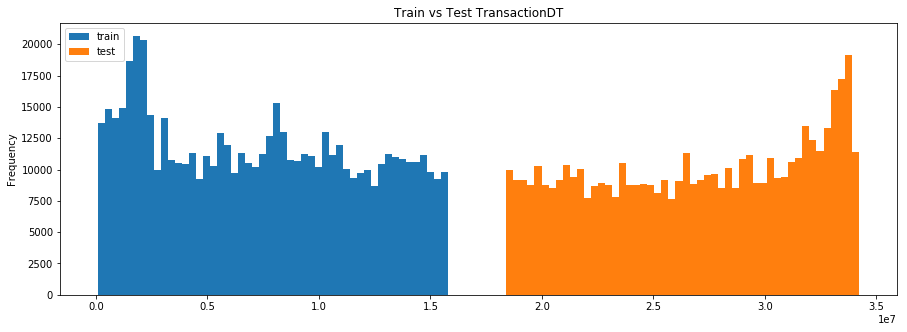

Total span of the records is 394.99936342592594
Total span of the train records is 181.99920138888888
Total span of the test records is 182.99908564814814


In [4]:
# Lets check the distribution of given train and test data
train['TransactionDT'].plot(kind='hist',figsize=(15, 5),label='train', bins=50,
                                        title='Train vs Test TransactionDT')
test['TransactionDT'].plot(kind='hist',label='test', bins=50)
plt.legend()
plt.show()
# We can see above that the test data doesn't have overlap with train data. So we may need to use
# time based spit for validation

trainDT_min = train['TransactionDT'].values.min()
trainDT_max = train['TransactionDT'].values.max()

testDT_min = test['TransactionDT'].values.min()
testDT_max = test['TransactionDT'].values.max()

print('Total span of the records is {}'.format((testDT_max - trainDT_min)/(24 * 60 * 60)))
print('Total span of the train records is {}'.format((trainDT_max - trainDT_min)/(24 * 60 * 60)))
print('Total span of the test records is {}'.format((testDT_max - testDT_min)/(24 * 60 * 60)))

In [5]:
# Lets try to extract new features for card features as they are categorical
# We can use transform in conjunction with groupby. The data point we would to like capture here answer the following question.
# "What percentage of TransactionAmount mean per category does each card feature represent?" 
for col in ['card1','card2','card4','card5','card6']:
    train['TransactionAmt_mean_to_'+str(col)]=(train['TransactionAmt']/train.groupby(col)['TransactionAmt'].transform('mean'))
    train['TransactionAmt_std_to_'+str(col)]=(train['TransactionAmt']/train.groupby(col)['TransactionAmt'].transform('std'))
    test['TransactionAmt_mean_to_'+str(col)]=(test['TransactionAmt']/test.groupby(col)['TransactionAmt'].transform('mean'))
    test['TransactionAmt_std_to_'+str(col)]=(test['TransactionAmt']/test.groupby(col)['TransactionAmt'].transform('std'))

# We can perform similar feature engineering on other categorical columns like 
for col in ['ProductCD', 'P_emaildomain','R_emaildomain','DeviceType','DeviceInfo','id_15','id_30','id_31','id_34']:
    train['TransactionAmt_mean_to_'+str(col)]=(train['TransactionAmt']/train.groupby(col)['TransactionAmt'].transform('mean'))
    train['TransactionAmt_std_to_'+str(col)]=(train['TransactionAmt']/train.groupby(col)['TransactionAmt'].transform('std'))
    test['TransactionAmt_mean_to_'+str(col)]=(test['TransactionAmt']/test.groupby(col)['TransactionAmt'].transform('mean'))
    test['TransactionAmt_std_to_'+str(col)]=(test['TransactionAmt']/test.groupby(col)['TransactionAmt'].transform('std'))

print(train.shape)
print(test.shape)

(590540, 397)
(506691, 396)


In [6]:
# Lets check how many categorical attributes exist
print(train.info())

# Lets fill all missing values with Nan
train.fillna(value=pd.np.nan, inplace=True)
test.fillna(value=pd.np.nan, inplace=True)

train['P_emaildomain'] = train['P_emaildomain'].str.split(".").str.get(0)
test['P_emaildomain'] = test['P_emaildomain'].str.split(".").str.get(0)
train['P_emaildomain'] = train['P_emaildomain'].str.split(".").str.get(0)
test['R_emaildomain'] = test['R_emaildomain'].str.split(".").str.get(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 397 entries, TransactionID to TransactionAmt_std_to_id_34
dtypes: float64(364), int64(4), object(29)
memory usage: 1.7+ GB
None


In [7]:
# From Info we can see that there are 29 Categorical columns
# Lets use LabelEncoder to convert them into numeric columns
# Label Encoding
from sklearn  import preprocessing
import numpy as np 

# Lets try to see the value counts of each category variable
# for col in train.columns:
#     if train[col].dtype == 'object':
#         print(train[col].value_counts())
        
for col in train.columns:
    if train[col].dtype == 'object':
        lbe = preprocessing.LabelEncoder()
        lbe.fit(list(train[col].values) + list(test[col].values))
        train[col] =lbe.transform(list(train[col].values))
        test[col]=lbe.transform(list(test[col].values))

def replace_inf_with_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

train = replace_inf_with_nan(train)
test = replace_inf_with_nan(test) 

In [8]:
# Lets impute all other column missing values with the median of that columns. 
# We haven't considered mean, because it sensitive to outliers.

for col in train.columns:
    train[col].fillna(train[col].median(),inplace=True) # fill with median because mean may be affect by outliers.

for col in test.columns:
    test[col].fillna(test[col].median(),inplace=True)

# Lets finally check the sum of nan/missing values should be zero
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

0
0


In [9]:
# Save the final dataset to Database
db_conn = Engine.get_db_conn()
# train.to_sql('train_final', db_conn, index=False)
# test.to_sql('test_final', db_conn, index=False)
train.to_csv('train_final.csv', index=False)
test.to_csv('test_final.csv', index=False)
print("Saved to Db")
# train.to_csv('CreditCardAutoML.csv', index=False)

Saved to Db


In [10]:
# Lets run PCA and see the variation among components
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
y = train['isFraud']
X = train.drop(['isFraud'], axis=1)
print(X.shape)
# print(X.head())

# Drop TransactionID and TransactionDT from X
X.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)

scaler = StandardScaler()
scaler.fit_transform(X)

print(X.head())

pca = PCA(n_components=10)
X_std_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

df_pca = pd.DataFrame(X_std_pca, columns=['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10'])
df_pca = pd.concat([y, df_pca], axis=1)
print(df_pca.head)
df_pca.to_csv('CreditCardPCAAutoML.csv', index=False)


(590540, 396)
   TransactionAmt  ProductCD  card1  card2  card3  card4  card5  card6  addr1  \
0            68.5          4  13926  361.0  150.0      1  142.0      1  315.0   
1            29.0          4   2755  404.0  150.0      2  102.0      1  325.0   
2            59.0          4   4663  490.0  150.0      4  166.0      2  330.0   
3            50.0          4  18132  567.0  150.0      2  117.0      2  476.0   
4            50.0          1   4497  514.0  150.0      2  102.0      1  420.0   

   addr2  ...  TransactionAmt_mean_to_DeviceInfo  \
0   87.0  ...                           0.769886   
1   87.0  ...                           0.769886   
2   87.0  ...                           0.769886   
3   87.0  ...                           0.769886   
4   87.0  ...                           0.362903   

   TransactionAmt_std_to_DeviceInfo  TransactionAmt_mean_to_id_15  \
0                          0.738306                      0.603859   
1                          0.738306             